# 0.0 IMPORTS

In [1]:
import inflection
import math
import datetime
import warnings
import pickle
import random
import seaborn                          as sns
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt
import xgboost                          as xgb

from scipy                 import stats as ss
from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from boruta                import BorutaPy
from tabulate              import tabulate

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) ) 
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False):

    mae_list= []
    mape_list= []
    rmse_list= []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: ', k)
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {
            'Model Name': model_name,
            'MAE CV': np.round( np.mean(mae_list), 2 ).astype(str) + " +/- " + np.round( np.std(mae_list), 2 ).astype(str),
            'MAPE CV': np.round( np.mean(mape_list), 2 ).astype(str) + " +/- " + np.round( np.std(mape_list), 2 ).astype(str),
            'RMSE CV': np.round( np.mean(rmse_list), 2 ).astype(str) + " +/- " + np.round( np.std(rmse_list), 2 ).astype(str)
        }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( (y-yhat) / y )

## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DATA DESCRIPTIONS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format(df1.shape[0]) )
print( 'Number of Columns: {}'.format(df1.shape[1]) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply(lambda x :200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

#promo2_since_week           
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

#promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#promo_interval              
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 
                                                              0 if x['promo_interval'] == 0 else 
                                                              1 if x['month_map'] in x['promo_interval'].split(',') else 0, 
                                                              axis = 1)

## 1.6 Check Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
# Alternative Code
# num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

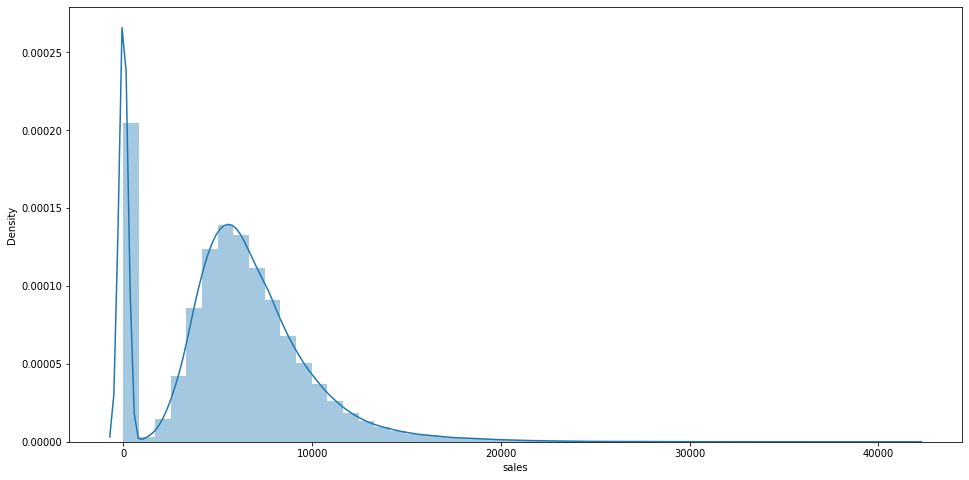

In [16]:
plt.figure(figsize = (16,8))
sns.distplot( df1['sales'] )

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

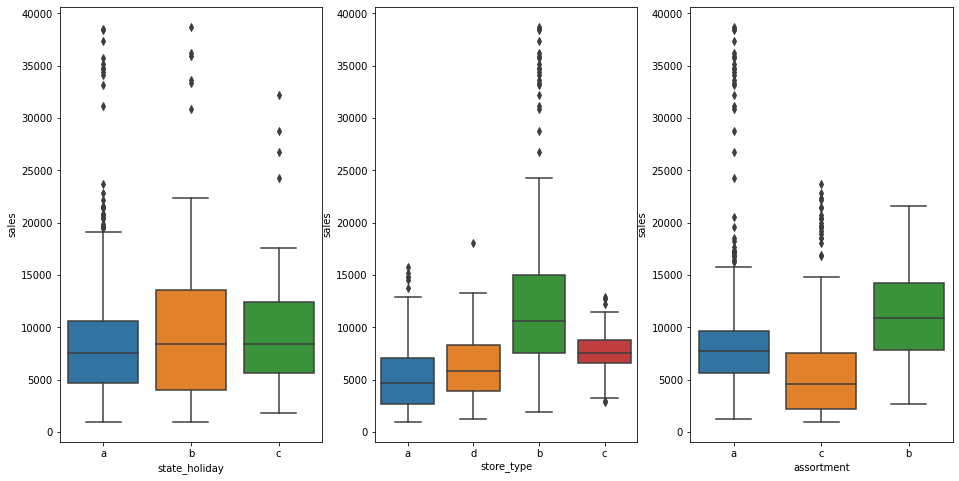

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize = (16,8))

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 - Mapa Mental de Hipoteses

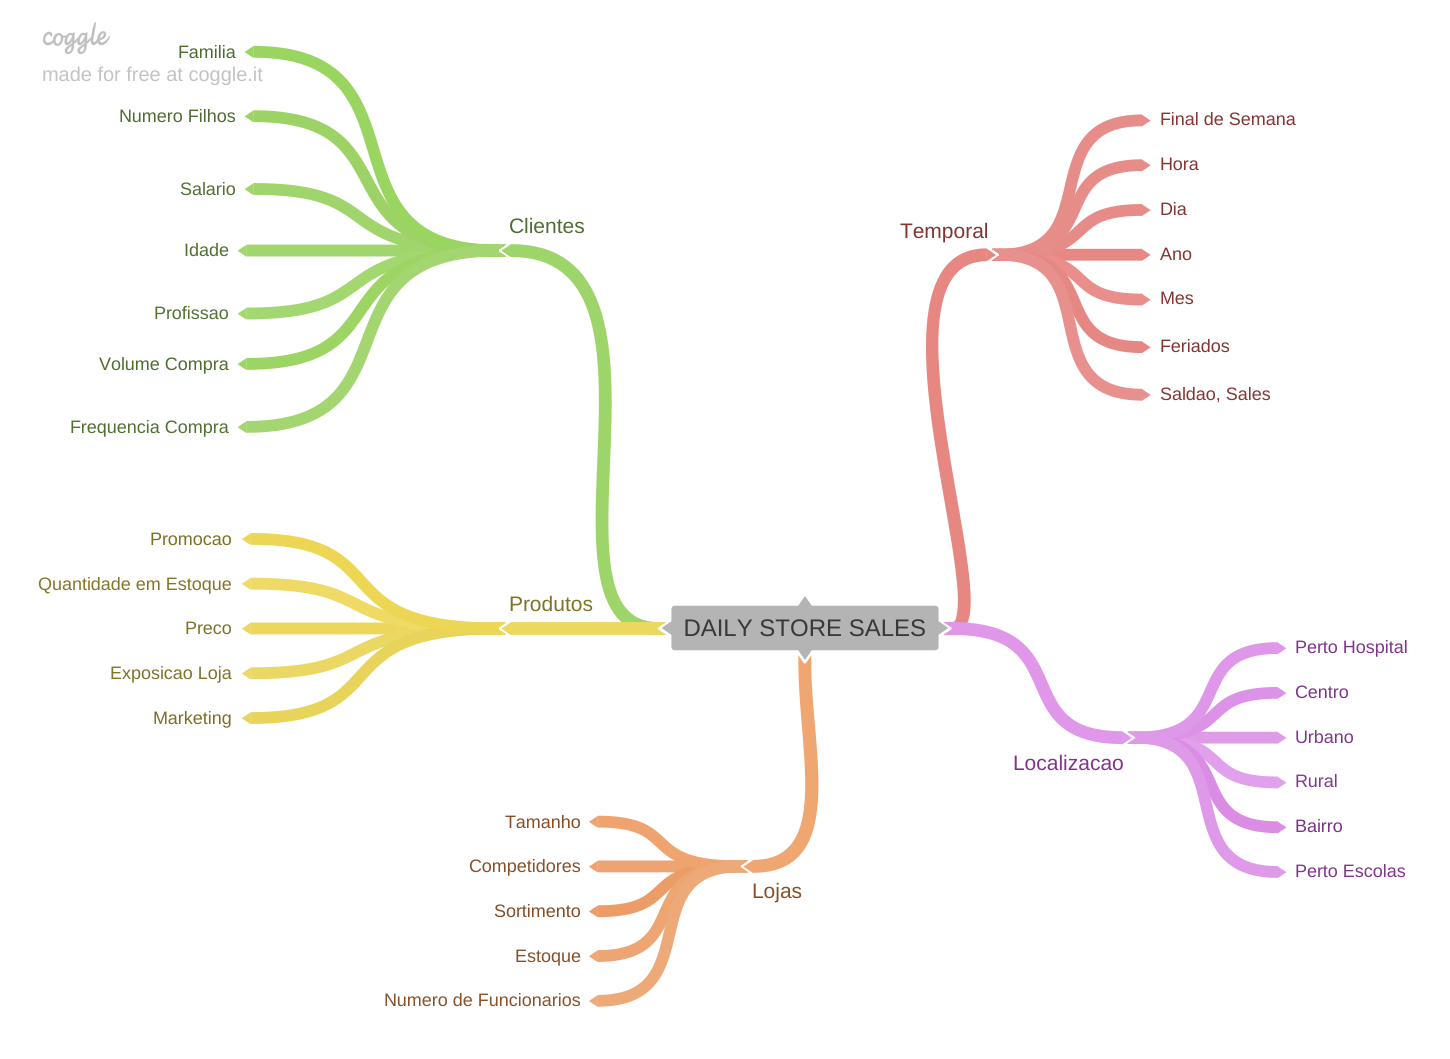

In [20]:
Image('photos/MindMapHypothesis.png')

## 2.2 - Criacao das Hipoteses

### 2.2.1 - Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 - Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 - Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos aos finais de semana.

## 2.4 - Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%M-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extented' )

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 DATA FILTERING

In [23]:
df3 = df2.copy()

## 3.1 - Filtragem das Linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Selecao das Colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, axis=1, inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

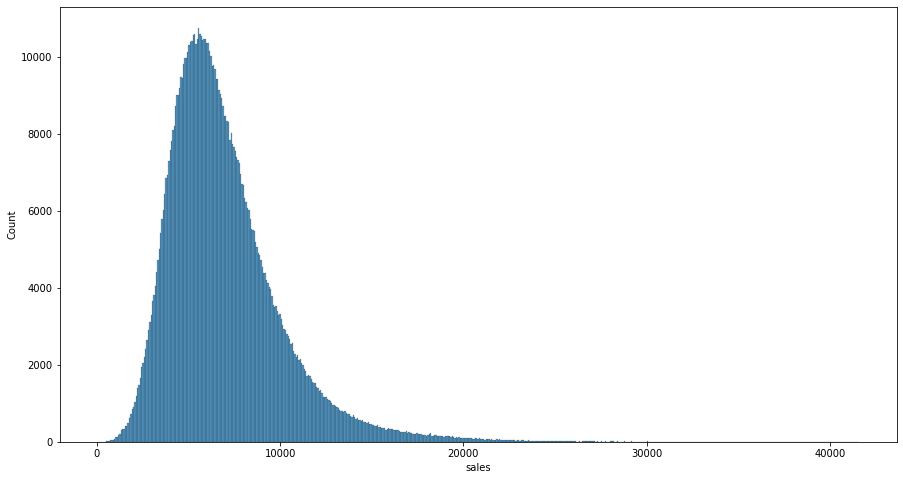

In [27]:
plt.figure(figsize=(15,8))
sns.histplot( df4['sales'] )

**sales** -> A variável resposta mostra uma skew positiva, em que a senoide demonstra mais à esquerda

### 4.1.2 - Numerical Variable

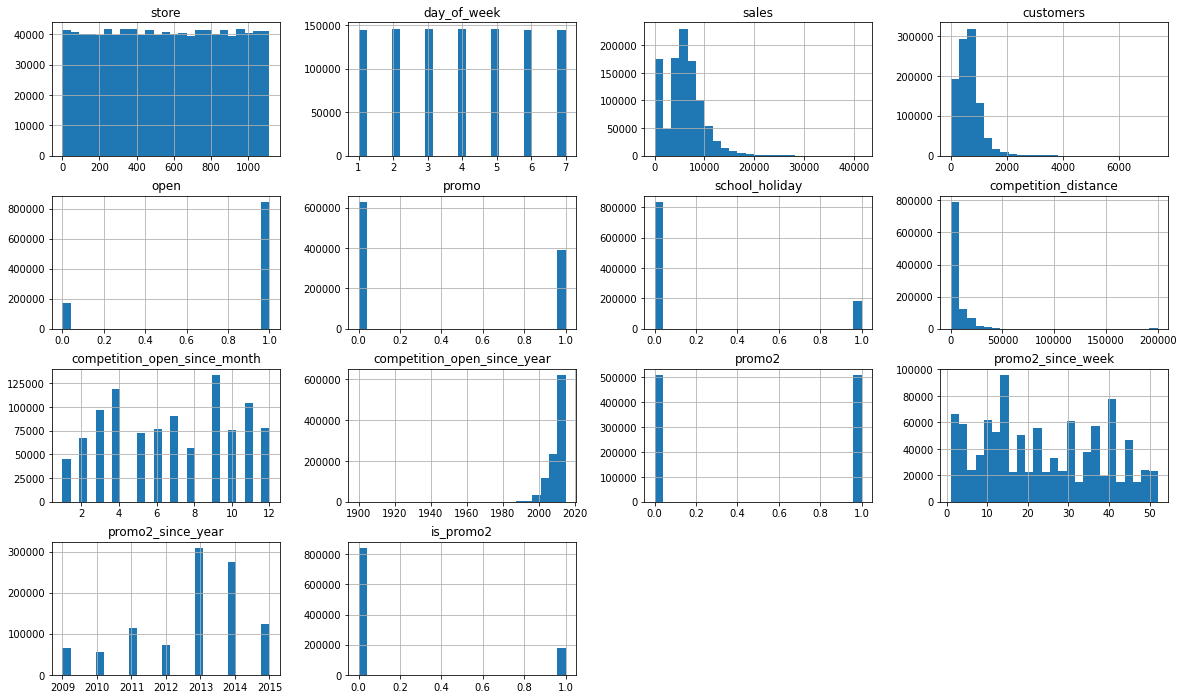

In [28]:
num_attributes.hist(figsize=(20,12), bins=25);

**store** -> Bem distribuida para cada loja, ou seja, temos uma quantidade de registros aproximado em cada unidade a ser considerada no estudo

**day_of_week** -> Isoladamente essa variável não demonstra muito valor, a partir do princípio que todos os dias contém vendas

**sales** -> Variável resposta especificada logo acima

**customers** -> Removida na seleção de colunas por identificar que não iremos distinguir clientes nesse primeiro ciclo

**open** -> Removida na selção de colunas por se tratar apenas de lojas abertas

**promo** -> 1/3 das unidades aderiram às promoções

**promo2** -> Metade das unidades que aderiram às promoções foram extendidas por mais um período ou se tornaram contínuas

**school_holiday** -> Feriados escolares não tem grande impacto nas vendas

**competition_distance** -> Maior volume de lojas próximas das outras

**competition_open_since_month** -> Nessa amostra temos que o maior volume de unidades com competições próximas inauguradas são com 4 e 9 meses.

**competition_open_since_year** -> Essa forte distribuição negativa representa que apenas a partir dos anos 2000 temos uma forte competição entre as unidades, isso se deve naturalmente ao crescimento da companhia

**promo2_since_week** -> A extensão das promoções por semanas estão bem dispersas com alguns picos entre as semanas 10 e 20. Deve ser mais aprofundado essa variável

**promo2_since_year** -> Já a extensão por anos foram intensificadas apenas em 2013 e 2014

**is_promo2** -> Concentração das promoções em determinados meses e feriados, deve ser mais investigado.

### 4.1.3 - Categorical Variable

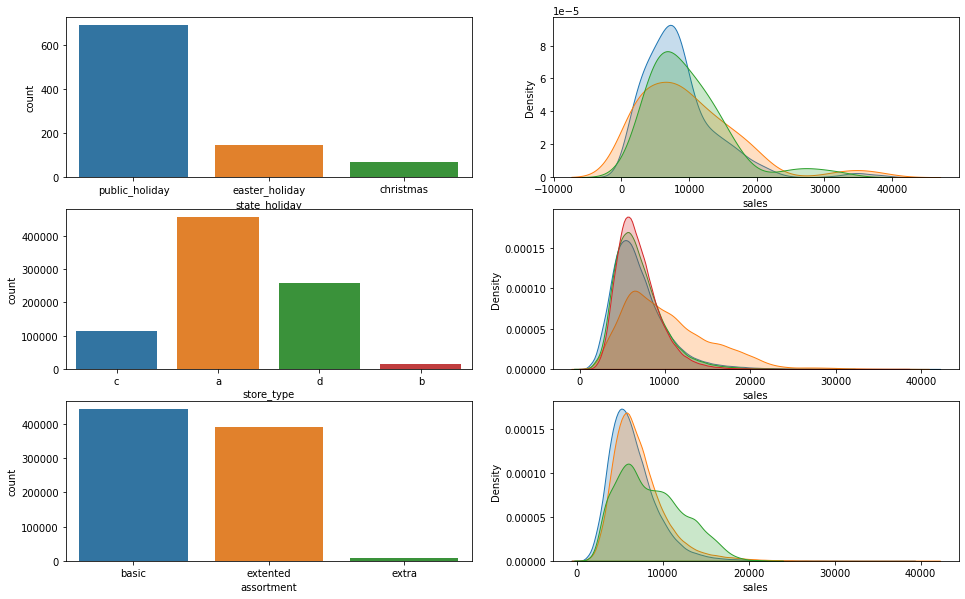

In [29]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize=(16,10))

plt.subplot( 3, 2, 1 )
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extented']['sales'], label='extented', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2 - Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais
**FALSA** - Lojas com maior sortimento vendem MENOS

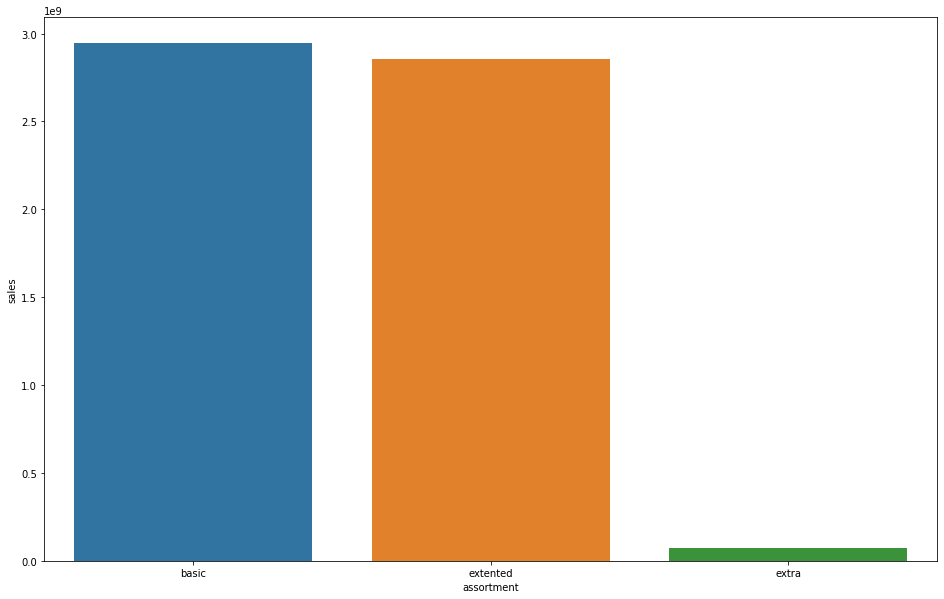

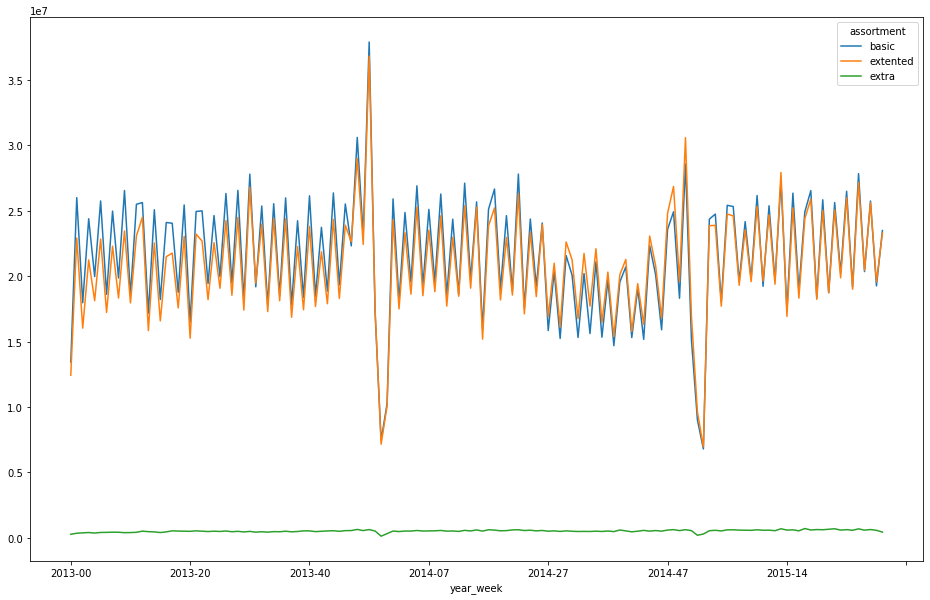

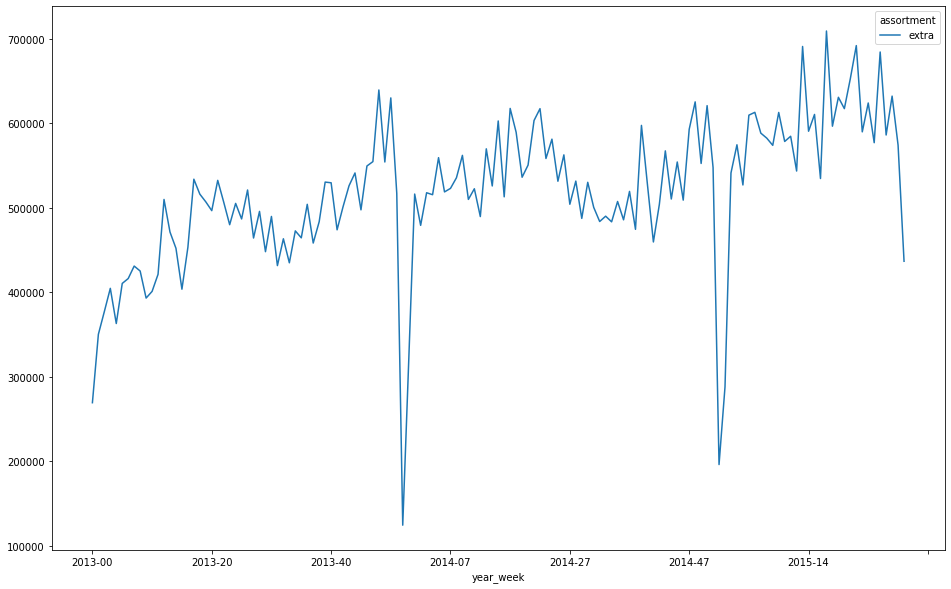

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(16,10))
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot(figsize=(16,10));

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(figsize=(16,10));

### H2 - Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com competidores mais próximos vende mais e não menos

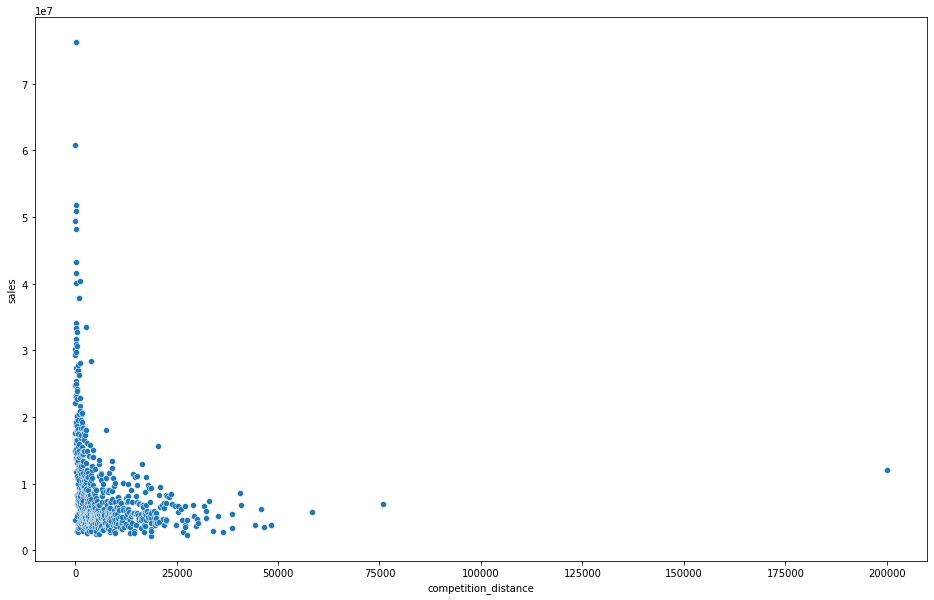

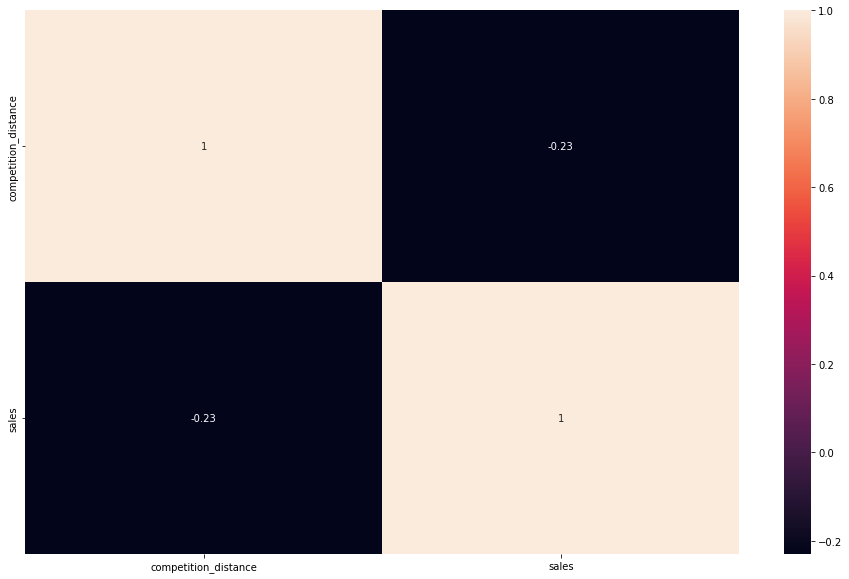

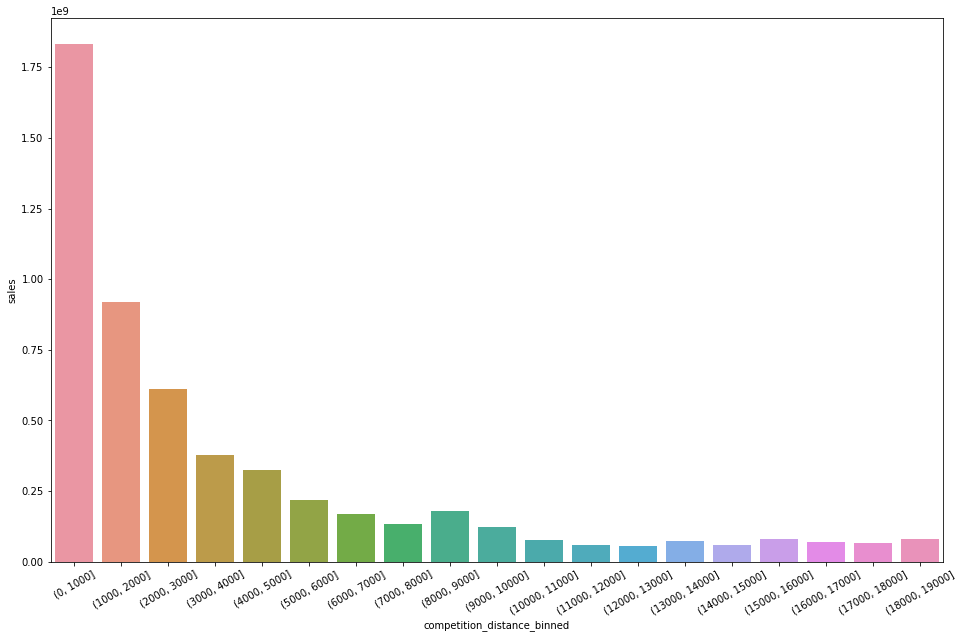

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(16,10))
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.figure(figsize=(16,10))
sns.heatmap( aux1.corr( method='pearson'), annot=True);

bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.figure(figsize=(16,10))
plt.xticks(rotation=30)
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

### H3 - Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com competidores a mais tempo vendem menos.

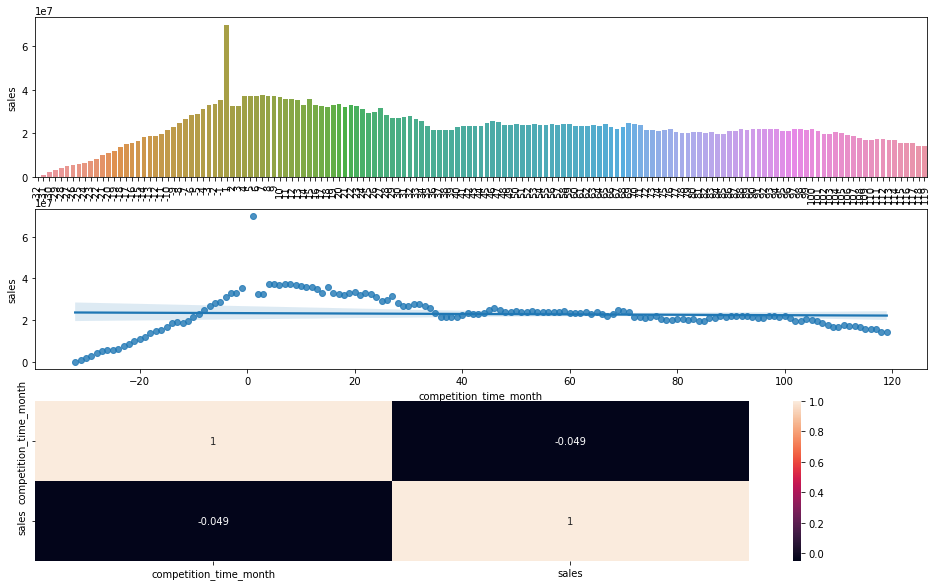

In [32]:
plt.figure(figsize=(16,10))

plt.subplot( 3, 1, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot( 3, 1, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 3, 1, 3 )
x = sns.heatmap( aux2.corr( method='pearson' ), annot=True );


### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

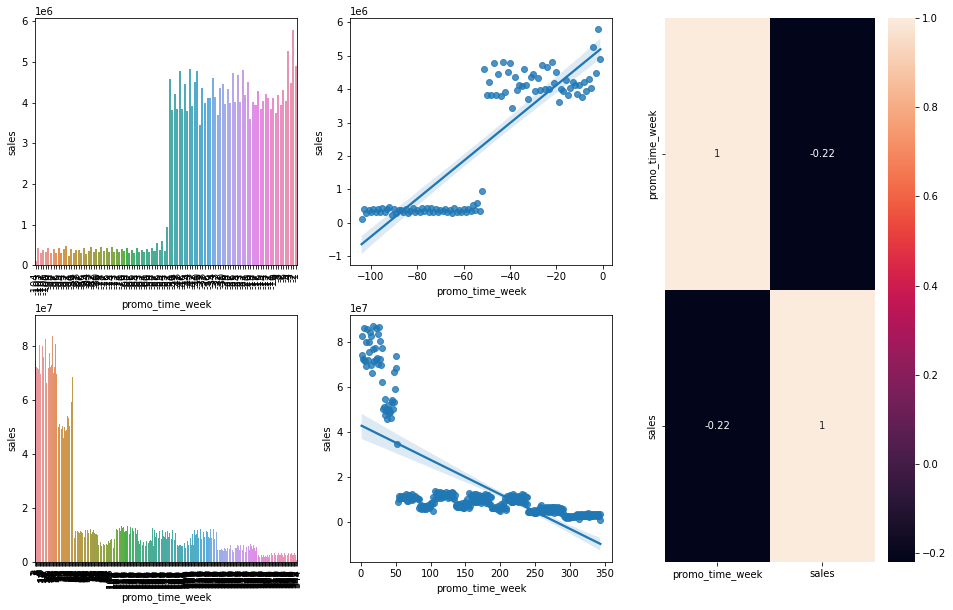

In [33]:
plt.figure(figsize=(16,10))

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] < 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] > 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks(rotation=90);

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5 - Lojas com mais dias de promoção deveriam vender mais.</s>

### H6 - Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


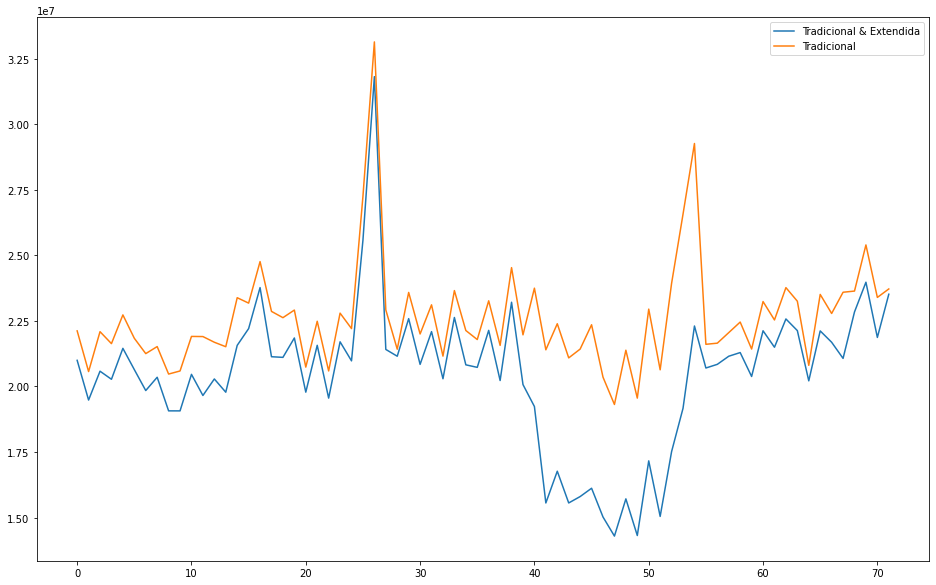

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(16,10))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(figsize=(16,10), ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o Natal vendem menos

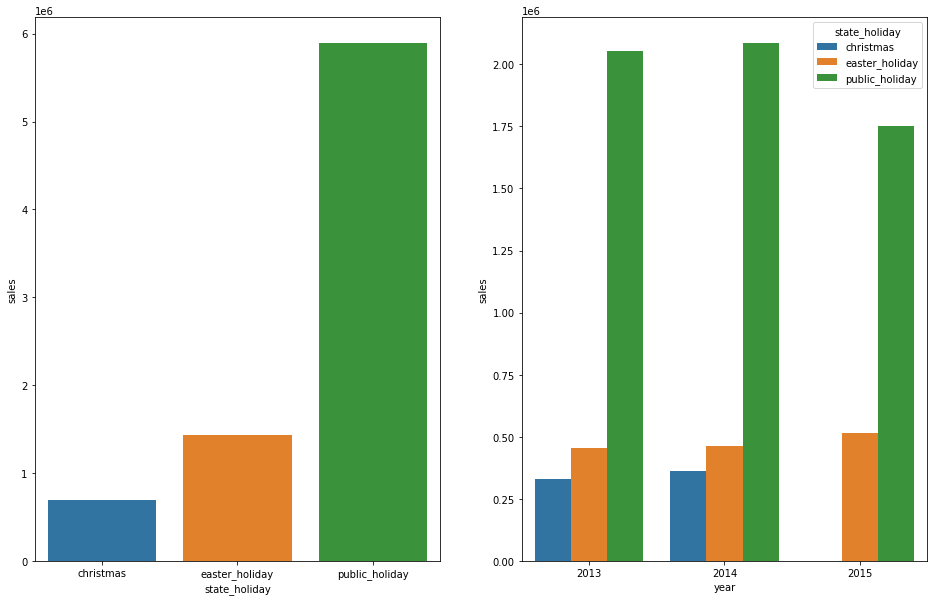

In [36]:
plt.figure(figsize=(16,10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

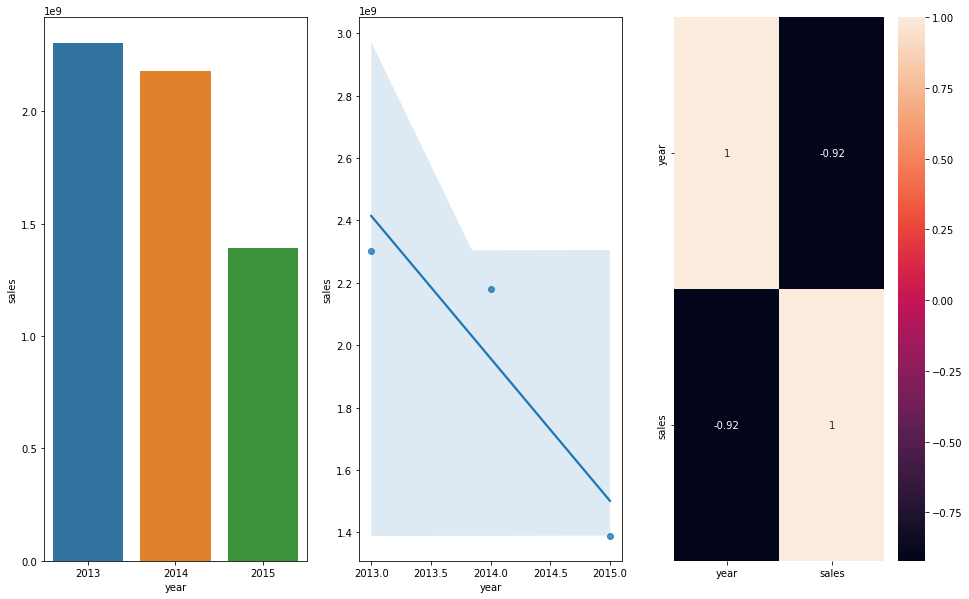

In [37]:
plt.figure(figsize=(16,10))
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem mais no segundo semestre do ano

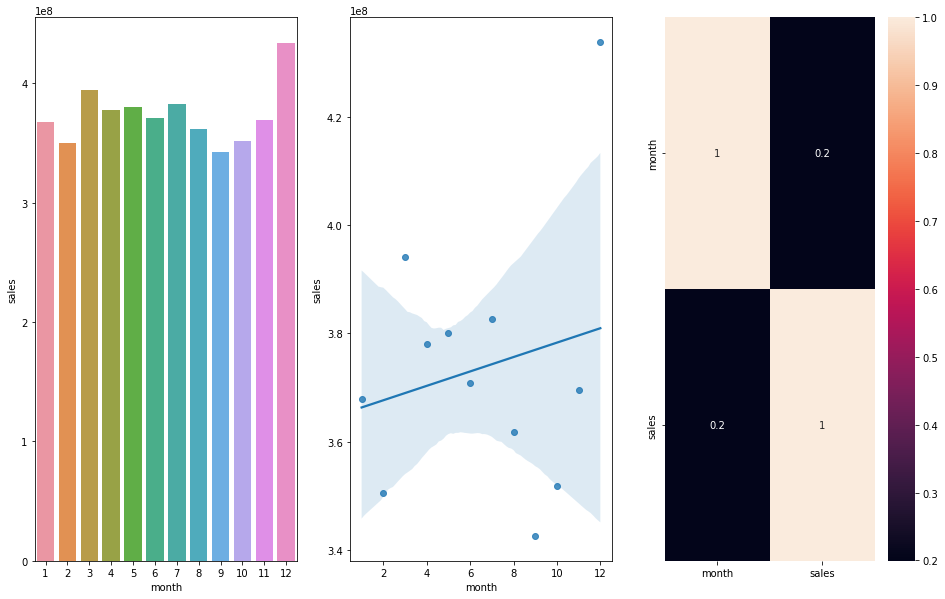

In [38]:
plt.figure(figsize=(16,10))

# Pelo ano de 2015 não estar fechado, foram considerados apenas os anos de 2013 e 2014
aux = df4[df4['year'] < 2015]
aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes

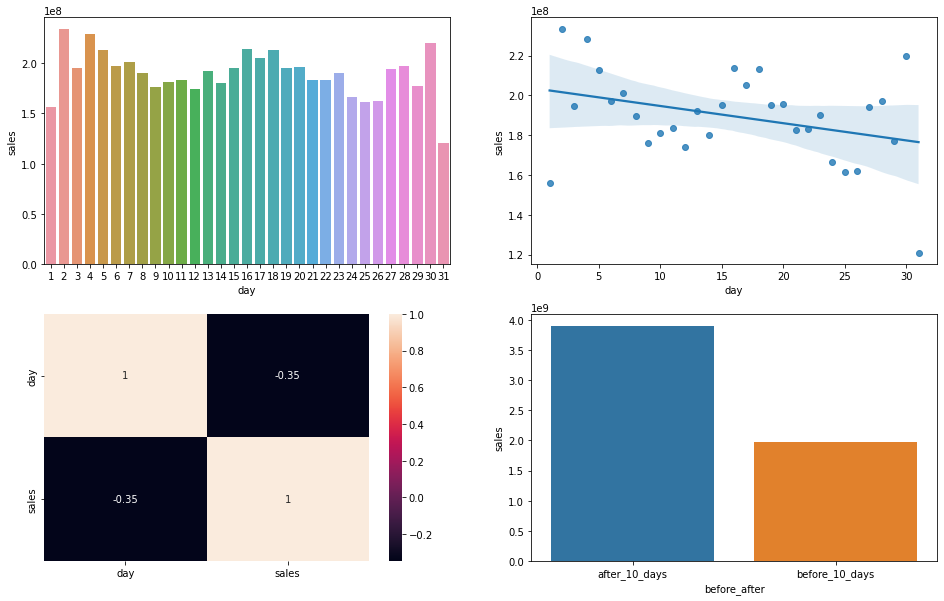

In [39]:
plt.figure(figsize=(16,10))
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos aos finais de semana

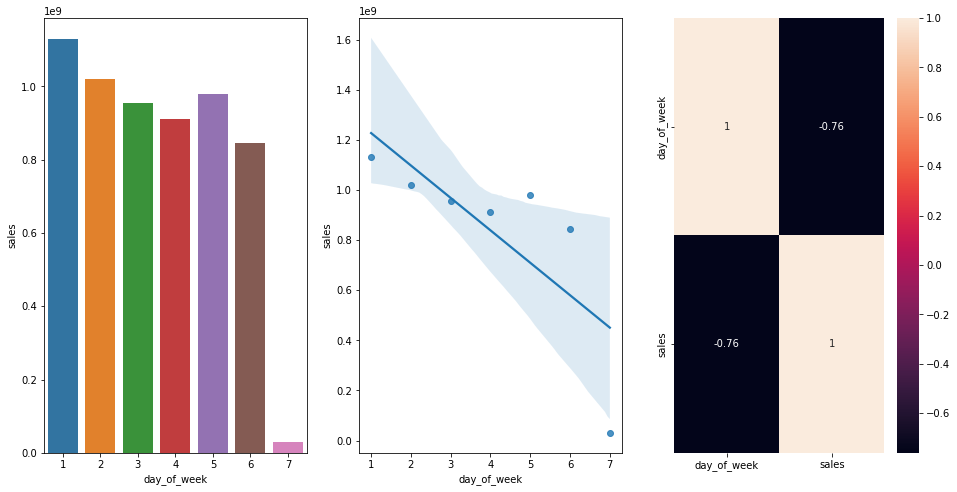

In [40]:
plt.figure(figsize=(16,8))
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

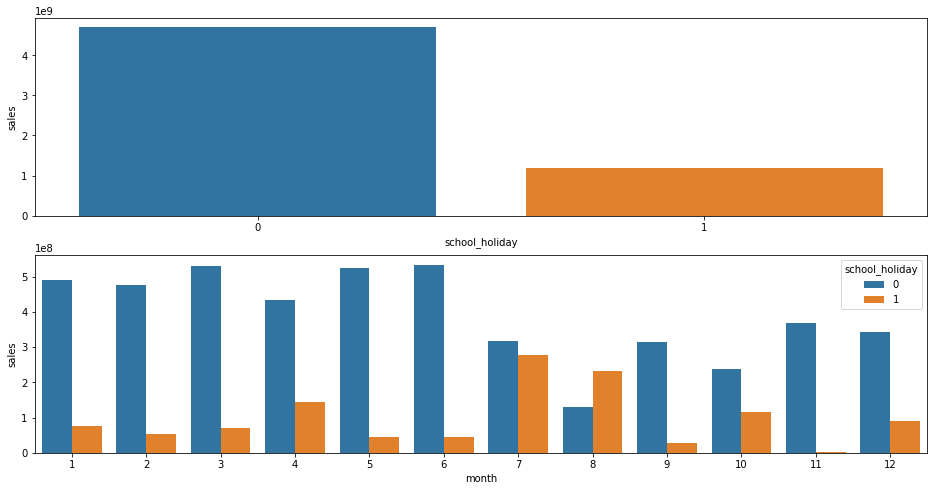

In [41]:
plt.figure(figsize=(16,8))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot( 2, 1, 2 )
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux2);

# plt.subplot( 1, 3, 2 )
# sns.regplot(x='school_holiday', y='sales', data=aux1);

# plt.subplot( 1, 3, 3 )
# sns.heatmap( aux1.corr(method='pearson'), annot=True );


## 4.3 - Multivariate Analysis

### 4.3.1 - Numerical Attributes

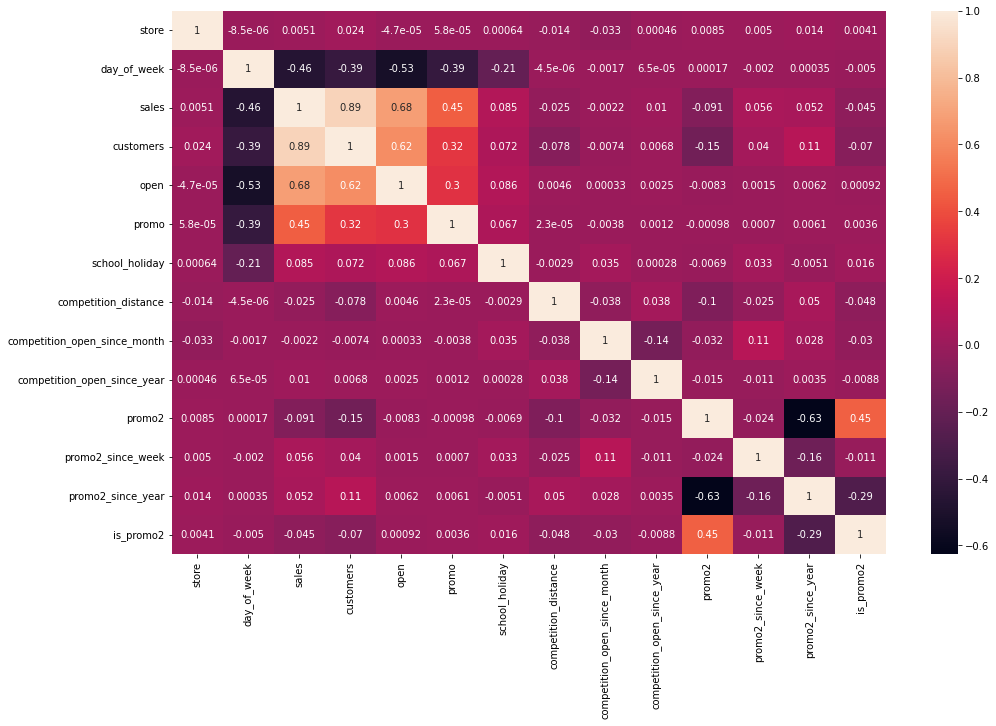

In [42]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 - Caterogical Attributes

In [43]:
a = df4.select_dtypes( include='object' )
a

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extented,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


<AxesSubplot:>

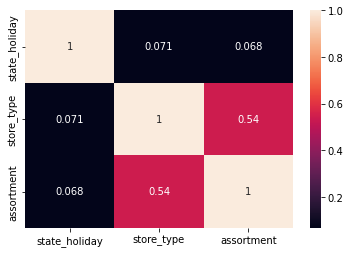

In [44]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type':    [a4, a5, a6],
                   'assortment':    [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )


## 4.4 - Resumo das Hipoteses

In [45]:
tab =[
['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Verdadeira', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa']
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


# 5.0 DATA PREPARATION

In [46]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

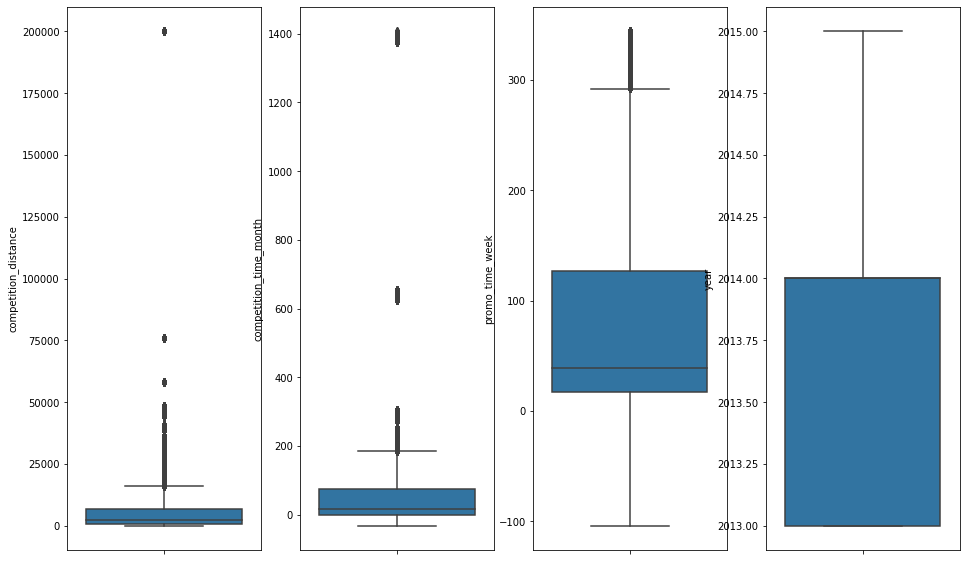

In [47]:
plt.figure(figsize=(16,10))

plt.subplot( 1, 4, 1 )
sns.boxplot(y=df5['competition_distance']);

plt.subplot( 1, 4, 2 )
sns.boxplot(y=df5['competition_time_month']);

plt.subplot( 1, 4, 3 )
sns.boxplot(y=df5['promo_time_week']);

plt.subplot( 1, 4, 4 )
sns.boxplot(y=df5['year']);

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb') )
 
# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb') )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb') )

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [49]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extented': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

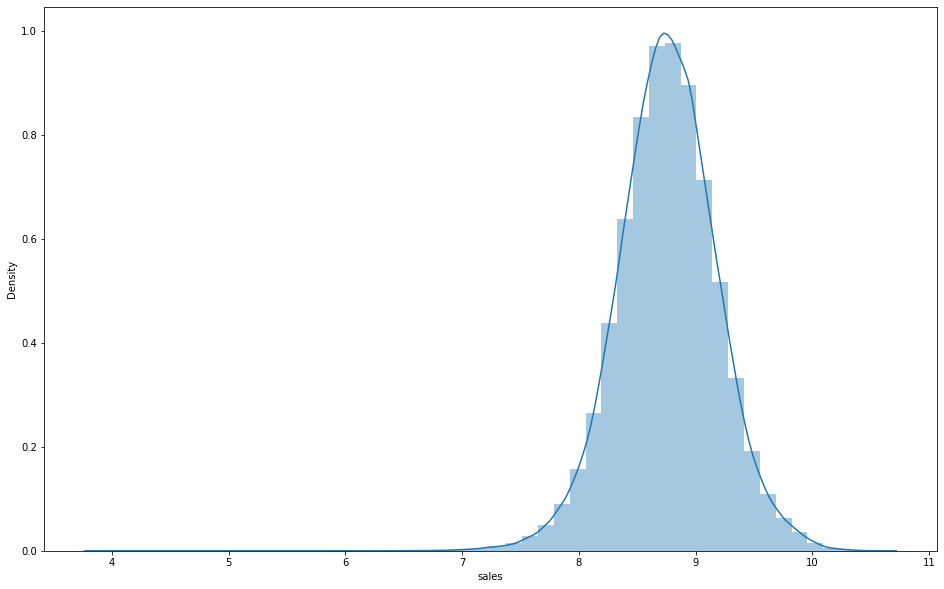

In [50]:
df5['sales'] = np.log1p( df5['sales'] )

plt.figure(figsize=(16,10))
sns.distplot(df5['sales'])

### 5.3.3 - Nature Transformation

In [51]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

In [52]:
df6 = df5.copy()

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6.drop(cols_drop, axis=1, inplace=True)

## 6.1 - Split Dataframe into training and test dataset

In [53]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [54]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [55]:
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [56]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=1 )

In [57]:
# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n , y_train_n )

### 6.2.1 - Best Features from Boruta

In [58]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_trains_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# # best features
# cols_not_selected_boruta = list(np.setdiff1d( X_trains_fs.columns, cols_selected_boruta ))

## 6.3 - Manual Feature Selection

In [59]:
cols_selected_boruta = []

# # columns to add
# feat_to_add = ['date', 'sales']

# # final features
# #cols_selected_boruta.extend( feat_to_add )

In [60]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [61]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[[ 'store', 'sales' ]].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [63]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.339339,0.292691,2671.718349


### 7.2.1 Linear Regression Model - Cross Validation

In [64]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1855.95 +/- 581.07,0.29 +/- 0.05,2696.75 +/- 929.06


## 7.3 Linear Regression Regularized Model - Lasso

In [65]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularizes Model Lasso - Cross Validation

In [66]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1862.95 +/- 613.96,0.28 +/- 0.04,2724.38 +/- 996.31


## 7.4 Random Forest Regressor

In [67]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,712.22332,0.104106,1077.714698


### 7.4.1 Random Forest Regressor - Cross Validation

In [68]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=True )
rf_result_cv


KFold Number:  5

KFold Number:  4

KFold Number:  3

KFold Number:  2

KFold Number:  1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,591.59 +/- 284.82,0.11 +/- 0.05,848.1 +/- 391.02


## 7.5 XGBoost Regressor

In [69]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_model_xgb = model_xgb.predict( x_test )

# performance
model_xgb_result = ml_error( 'XGBoost', np.expm1(y_test), np.expm1(yhat_model_xgb) )
model_xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,726.98459,0.104382,1052.385247


### 7.5.1 XGBoost - Cross Validation

In [70]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost', model_xgb, verbose=True )
xgb_result_cv


KFold Number:  5

KFold Number:  4

KFold Number:  3

KFold Number:  2

KFold Number:  1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,687.12 +/- 402.11,0.11 +/- 0.05,1009.18 +/- 652.9


## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [71]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, model_xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost,726.984590,0.104382,1052.385247
0,Random Forest Regressor,712.223320,0.104106,1077.714698
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.339339,0.292691,2671.718349
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [72]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1855.95 +/- 581.07,0.29 +/- 0.05,2696.75 +/- 929.06
0,Lasso,1862.95 +/- 613.96,0.28 +/- 0.04,2724.38 +/- 996.31
0,Random Forest,591.59 +/- 284.82,0.11 +/- 0.05,848.1 +/- 391.02
0,XGBoost,687.12 +/- 402.11,0.11 +/- 0.05,1009.18 +/- 652.9


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [73]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [74]:
# final_result = pd.DataFrame()
# 
# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)
# 
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
# 
#     # performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb )
#     final_result = pd.concat([final_result, result])
#     
# final_result

## 8.2 Final Model

In [75]:
param_tuned = {
    'n_estimators': 3000,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}

In [76]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,676.204179,0.097506,975.010871


In [77]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.011966720225641266

# 9.0 TRANSLATE AND INTERPRETATION ERROR

In [78]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['prediction'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [79]:
# sum of predictions
df91 = df9[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'], x['prediction']) ).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'], x['prediction']) ).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarious
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sample(5)

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
346,347,185839.828125,185365.027146,186314.629104,474.800979,0.083943
592,593,326598.062500,325446.741198,327749.383802,1151.321302,0.117549
870,871,243959.031250,243147.793048,244770.269452,811.238202,0.115524
749,750,194088.500000,193405.790738,194771.209262,682.709262,0.137528
67,68,277356.843750,276384.728951,278328.958549,972.114799,0.114054


In [81]:
# Stores with worst scenarious
df92.sort_values( 'MAPE', ascending=False ).head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
291,292,103918.226562,100694.054109,107142.399016,3224.172453,0.530180
908,909,252882.578125,245442.178223,260322.978027,7440.399902,0.526043
875,876,213974.750000,209792.184337,218157.315663,4182.565663,0.315730
721,722,352779.906250,350793.854439,354765.958061,1986.051811,0.261115
273,274,200992.093750,199729.583706,202254.603794,1262.510044,0.218638


<AxesSubplot:xlabel='store', ylabel='MAPE'>

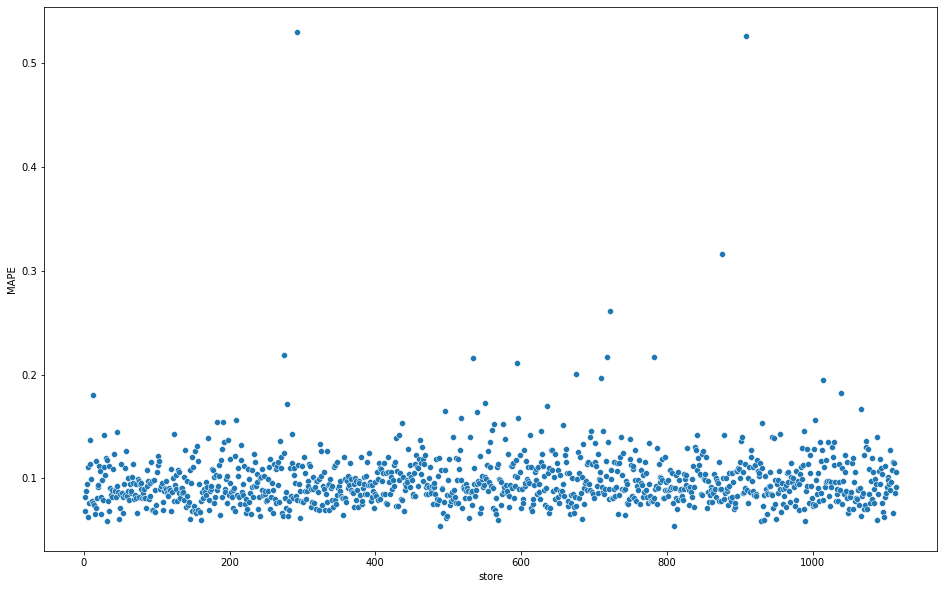

In [82]:
plt.figure(figsize=(16,10))
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [83]:
df93 = df92[[ 'prediction', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,prediction,"R$282,653,248.00"
1,worst_scenario,"R$281,895,280.61"
2,best_scenario,"R$283,411,239.05"


## 9.3 Macinhe Learning Performance

In [84]:
df9['error'] = df9['sales'] - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['sales']

<AxesSubplot:xlabel='prediction', ylabel='error'>

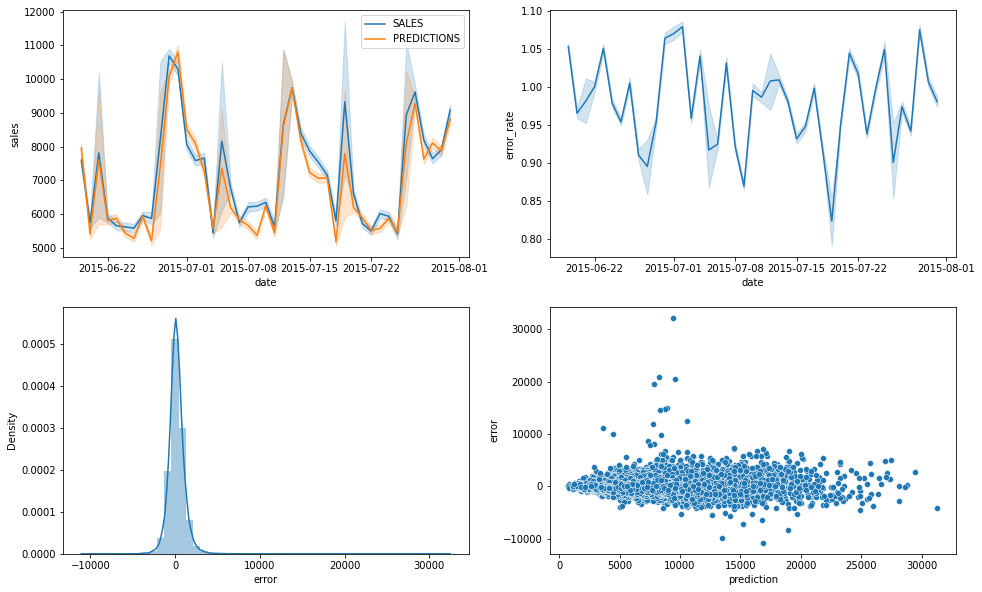

In [85]:
plt.figure(figsize=(16,10))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='prediction', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9)

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['prediction'], df9['error'] )